# Meteoroid Simulator

## Tyler Witt & Kieran Yanaway

&emsp; This notebook contains the code necessary to simulate the acoustic wave produced by a meteoroid travelling through Earth's atmosphere. The purpose of this code is to provide an idea of the kind of seismic signal which might be expected to express itself on the ground once the infrasound generated by a meteoroid collides with the surface of the ground. Many assumptions currently exist, meaning there is a low likelihood this represents an actual seismic response to a meteoroid acoustic wave.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import *

from matplotlib import animation
from IPython.display import HTML,Image

&emsp; First, we assume this problem can be modeled as an acoustic wave travelling through the atmosphere, then arriving at a ground surface. This modelling is done using an eighth order finite difference method acoustic wave equation solver.

In [2]:
def eighth_order_2d_awe_hetv(Uc, Up, dx, dy, dt, v, F, it, sx, sy):
    """
    Uc : State of wavefield prior to current timestep
    
    Up : Once returned, contains the state of wavefield at current timestep
    
    dx : Discretization in x (kilometers)
    
    dy : Discretization in y (kilometers)
    
    dt : Discretization in time
    
    v : Velocity field (kilometers per time)
    
    F : Forcing function (meteoroid atmospheric disturbance magnitude as a function of time)
    
    it : Time step for forcing function
    
    sx : Location of meteoroid in x as a function of time (km)
    
    sy : Location of meteoroid in y as a function of time (km)
    """
    ny,nx = Uc.shape

    dtdx2,dtdy2 = (dt/dx)**2, (dt/dy)**2
    
    isx,isy = int(sx[it]/dx),int(sy[it]/dy)
    
    if isx >= 1 and isx < nx - 1 and isy >= 1 and isy < ny - 1:
        # Add meteoroid forcing at (sx,sy), and adjacent points.
        Uc[isy,isx] += dt*dt*F[it]
        Uc[isy-1,isx] += dt*dt*F[it]
        Uc[isy+1,isx] += dt*dt*F[it]
        Uc[isy,isx-1] += dt*dt*F[it]
        Uc[isy,isx+1] += dt*dt*F[it]
        
    v2 = v[4:-4,4:-4]*v[4:-4,4:-4]

    Up[4:ny-4,4:nx-4] = 2*Uc[4:ny-4,4:nx-4]-Up[4:ny-4,4:nx-4] + dtdy2*(v2)*(
                    -1/560 *Uc[0:ny-8,4:nx-4]
                    +8/315 *Uc[1:ny-7,4:nx-4]
                    -1/5 *Uc[2:ny-6,4:nx-4]
                    +8/5 *Uc[3:ny-5,4:nx-4]
                    -205/72 *Uc[4:ny-4,4:nx-4]
                    +8/5 *Uc[5:ny-3,4:nx-4]
                    -1/5 *Uc[6:ny-2,4:nx-4]
                    +8/315 *Uc[7:ny-1,4:nx-4]
                    -1/560 *Uc[8:ny,4:nx-4]) + dtdx2*(v2)*(
                    -1/560 *Uc[4:ny-4,0:nx-8]
                    +8/315 *Uc[4:ny-4,1:nx-7]
                    -1/5 *Uc[4:ny-4,2:nx-6]
                    +8/5 *Uc[4:ny-4,3:nx-5]
                    -205/72 *Uc[4:ny-4,4:nx-4]
                    +8/5 *Uc[4:ny-4,5:nx-3]
                    -1/5 *Uc[4:ny-4,6:nx-2]
                    +8/315 *Uc[4:ny-4,7:nx-1]
                    -1/560 *Uc[4:ny-4,8:nx])
    kappa = v * dt / dx
    
    Up[:,:4] = Uc[:,1:5] + (kappa[:,:4]-1)/(kappa[:,:4]+1) * (Up[:,1:5] - Uc[:,:4])
    
    Up[:,-5:] = Uc[:,-6:-1] + (kappa[:,-5:]-1)/(kappa[:,-5:]+1) * (Up[:,-6:-1] - Uc[:,-5:])

    Up[:4] = Uc[1:5] + (kappa[:4]-1)/(kappa[:4]+1) * (Up[1:5] - Uc[:4])

    Up[-5:] = Uc[-6:-1] + (kappa[-5:]-1)/(kappa[-5:]+1) * (Up[-6:-1] - Uc[-5:])
    return Up

In [3]:
ny = 400 # Number of discretized y
nx = 600 # Number of discretized x
gy = int(0.75 * ny) # Location of ground surface (out of y)
dy = 5 # kilometers
dx = 5 # kilometers
x = np.linspace(0,nx*dx,nx)
y = np.linspace(0,ny*dy,ny)

vat = 0.343 # atmospheric velocity, km/s
vg = 5 # ground velocity, km/s
vf = np.ones((ny+8,nx+8)) * vat # velocity field
vf[gy+4:] = vg # Add velocity of ground

In [4]:
Uc = np.zeros((ny+8,nx+8)) # Current wavefield state
Up = np.zeros_like(Uc) # Previous wavefield state

C = 0.1 # Constant for finding dt (must be less than 1)
nt = 10000 # Number of timesteps
dt = C * dx / np.max(vf) # timestep, seconds
t = np.linspace(0,nt*dt,nt) # Time axis, seconds

&emsp; The next assumption is that the meteoroid follows a straight path through the atmosphere, starting at some arbitrary point in the upper atmosphere and ending some number (on the order of 10s of kilometers) above the ground surface. This takes the form of a forcing function for the wavefield that adds a constant magnitude to cells along the meteoroid path until the meteoroid ablates.

In [5]:
mag = 1000 # Meteoroid magnitude (arbitrary as of right now)
vel = 34.3 # Meteoroid velocity (km/s, ranges from around mach 35 to mach 240)
inity = 450 # km
initx = 2300 # km
dang = np.pi / 4 # Descent angle, radians (angle of incidence)
F = np.ones(nt) * mag # Forcing function
sy = np.sin(dang) * vel * t + inity # Forcing y location
sx = -np.cos(dang) * vel * t + initx # Forcing x location

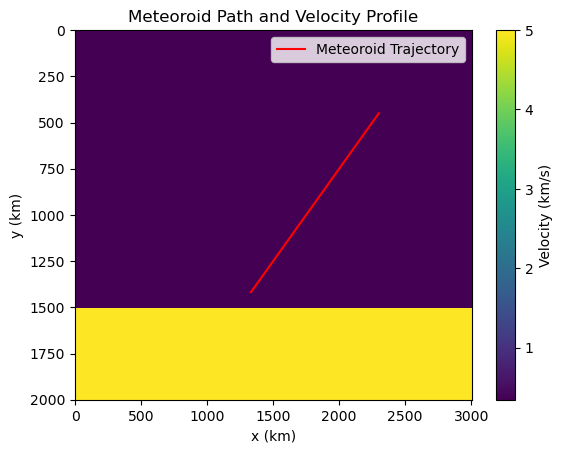

In [6]:
nmt = 400 # Number of meteor timesteps before it ablates
finy = sy[nmt] # Y position at ablation
finx = sx[nmt] # X Position at ablation
F[nmt:] = 0 # Ablate after nmt
F[nmt] = 10 * mag # Increase magnitude to simulate ablation energy release

plt.pcolormesh(x,y,vf[4:-4,4:-4])
plt.ylim(ny*dy,0)
plt.plot(sx[:nmt],sy[:nmt],c="r",label="Meteoroid Trajectory")
plt.xlabel("x (km)")
plt.ylabel("y (km)")
plt.colorbar(label="Velocity (km/s)")
plt.title("Meteoroid Path and Velocity Profile")
plt.legend()
plt.show()

In [7]:
print("Incident Angle (degrees):", np.rad2deg(dang))
print("Final y position (km):", finy)
print("Final x position (km):", finx)

Incident Angle (degrees): 45.0
Final y position (km): 1420.2475285407972
Final x position (km): 1329.7524714592028


In [8]:
hc = np.zeros((nt,ny+8,nx+8)) # 3D Array holds wavefield at each timestep

for i in range(nt):
    tmp = eighth_order_2d_awe_hetv(Uc, Up, dx, dy, dt, vf, F, i, sx, sy)
    hc[i] = tmp
    Up = Uc
    Uc = tmp

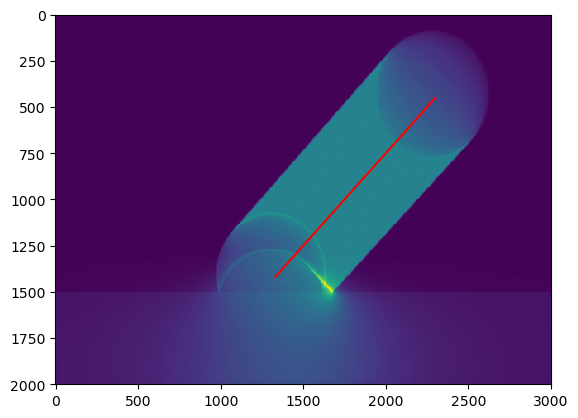

In [9]:
tstep = 9999
plt.pcolormesh(x,y,hc[tstep,4:-4,4:-4]+100*vf[4:-4,4:-4]) # Plot wavefield at timestep tstep
plt.ylim(ny*dy,0)
plt.plot(sx[:nmt],sy[:nmt],c="r")
plt.show()

In [10]:
vgline = vg * t + finx # Line to visualize ground velocity of waves
vatline = vat * t + finx # Line to visualize atmospheric velocity of waves
tinit = nmt*dt + (gy * dy - finy) / vat # Initial time (arrival of atmospheric wave at ground)

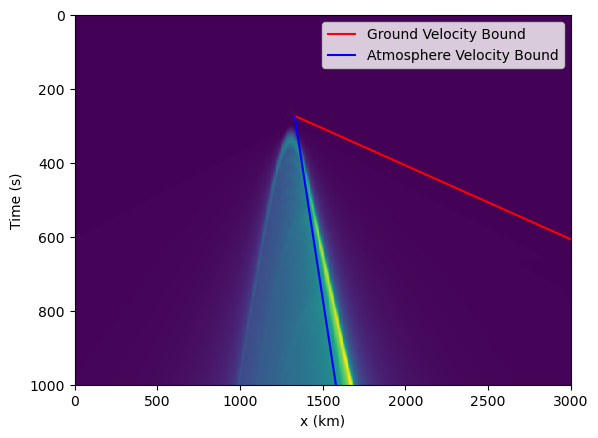

In [11]:
plt.pcolormesh(x,t,hc[:,gy+4,4:-4])
plt.plot(vgline,tinit+t,c="r",label="Ground Velocity Bound")
plt.plot(vatline,tinit+t,c="b",label="Atmosphere Velocity Bound")
plt.ylim(t[-1],0)
plt.xlim(0,nx*dx)
plt.legend()
plt.ylabel("Time (s)")
plt.xlabel("x (km)")
plt.show()